In [154]:
# Computational Methods
# Term Project: Kalman Filters for Energy Systems
# Stefan Deutsch, Viv Pitter, Ansel Klein
# Prof. Anthoff
# Due 5/12/17

# Parameters

R1A = 5 # Thermal resistance between Room 1 and ambient, deg C/kW
R12 = 3 # Thermal resistance between Room 1 and Room 2, deg C/kW
R23 = 3 # Thermal resistance between Room 2 and Room 3, deg C/kW
R3A = 5 # Thermal resistance between Room 3 and ambient, deg C/kW
C1 = 24  # Thermal capacitance of Room 1, kWh/deg C
C2 = 15  # Thermal capacitance of Room 2, kWh/deg C
C3 = 48  # Thermal capacitance of Room 3, kWh/deg C
P = 8  # Thermal power of heater, kW

# State space matrices
A = [-1/C1*(1/R1A + 1/R12) 1/(C1*R12) 0; 1/(C2*R12) -1/C2*(1/R12 + 1/R23) 1/(C2*R23); 0 1/(C3*R23) -1/C3*(1/R23 + 1/R3A)]
B = [1/(C1*R1A) P/(2*C1); 0 0; 1/(C3*R3A) P/(2*C3)]
C = [0 1 0]
D = [0 0]

# Compute observability Matrix for 3-state system and rank
O = [C; C*A; C*A^2]
r = rank(O)  # could also do this by inspection?
println("Rank of the observability matrix is $r.\n")

# Upload data here

# t = time series vector
t = collect(1:1:72)'

using ExcelReaders
tempdata = readxl("/Users/vivpitter/Downloads/Building Data for Ansel.xlsx", "Raw Data!C2:E73")

# T_A = vector of ambient temperature data
T_A = readxl("/Users/vivpitter/NOAA Oakland Temp Data.xlsx", "Sheet1!G8:G79")[:,1]
T_A = [i for i in T_A]'
# s = 0 or 1 depending on whether heater is on or off
s = [(i == "ON") + 0 for i in tempdata[:,1]]'
# T_2 = vector of sensed temperature data in room 2
T_2 = tempdata[:,3]
T_2 = [i for i in T_2]'

u = [T_A; s]  # collect ambient temperature and heater state into input matrix
ym = T_2  # temperature of room 2 is state of interest and thus the measured output

# x0 = mean initial states (arbitrary)
# sig0 = covariance of initial states (arbitrary)

# Kalman Filter

# Noise covariances
W = diagm([.05; .02; .05])  # Covariance of model inaccuracy / process noise  We tune this to our liking.
N = 1.5  # Covariance of sensor noise, just an example right now
sig0 = 1.5*eye(3) # just an example right now

# Estimated Initial Conditions
# x_hat0 = x0
x_hat0 = [20; 20; 20]  # just an example right now

# Simulate Kalman Filter
# original equation was [tsim,states] = ode45(@(t,x) ode_kf(t,x,A,B,C,D,input_data,W,N),t,states0) where 'states' combined x and sigma
# i.e. [tsim, xsim, sigsim] = our_ode(kalman(x_hat,sig,A,B,C,D,ym,u,W,N), t, x_hat0, sig0)
#(x_hat, sig) = Euler(kalman,A,B,C,D,ym,u,W,N,t,x_hat0,sig0)  # using Euler's method right now
(x_hat, sig) = kalmanRKF45(kalman,A,B,C,D,ym,u,W,N,t,x_hat0,sig0)

# Parse States
T1_hat = x_hat[1,:]'
T2_hat = x_hat[2,:]'
T3_hat = x_hat[3,:]'
# Compute the upper and lower bounds on T1 and T3
bound1 = zeros(length(t))'
bound3 = zeros(length(t))'
for k in 1:length(t)
    bound1[k] = sig[k][1,1]
    bound3[k] = sig[k][3,3]
end

# Calculate RMSE between sensor and estimated T2
rmse = (sum((T2_hat-T_2).^2)/length(T_2))^0.5

# Plot results
println("time series vector: ",t,"\n")
println("heater setting: ",s,"\n")
println("ambient temperature data: ",T_A,"\n")
println("room 1 estimated temperature: ",T1_hat,"\n")
println("room 2 estimated temperature: ",T2_hat,"\n")
println("room 3 estimated temperature: ",T3_hat,"\n")
# Plot true and estimated T2 versus time
println("room 2 sensor data: ",T_2,"\n")
println("room 2 estimated temperature: ",T2_hat,"\n")
# Plot estimated T1 and T3 plus/minus 1 sigma
println("room 1 estimate high bound: ",T1_hat+bound1,"\n")
println("room 1 estimate low bound: ",T1_hat-bound1,"\n")
println("room 3 estimate low bound: ",T3_hat+bound3,"\n")
println("room 3 estimate low bound: ",T3_hat-bound3,"\n")
# Plot error between true and estimated T2
println("room 2 sensor prediction error: ",T2_hat-T_2,"\n")
println("root mean squared error: ",rmse,"\n")


Rank of the observability matrix is 3.

time series vector: [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]

heater setting: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

ambient temperature data: [70.0 73.0 75.0 78.0 79.0 81.0 85.0 79.0 75.0 70.0 67.0 65.0 63.0 56.0 55.0 55.0 57.0 58.0 58.0 58.0 58.0 60.0 61.0 62.0 63.0 66.0 69.0 69.0 74.0 74.0 74.0 75.0 71.0 66.0 63.0 61.0 60.0 53.0 54.0 54.0 54.0 54.0 54.0 55.0 57.0 58.0 60.0 61.0 63.0 68.0 71.0 71.0 73.0 77.0 79.0 78.0 75.0 74.0 75.0 69.0 67.0 62.0 57.0 59.0 61.0 62.0 62.0 63.0 62.0 61.0 62.0 63.0]

room 1 estimated temperature: [20.0 21.2001 22.776 24.5207 26.3991 28.3619 30.3426 32.3221 34.1202 35.6968 37.1635 38.4376 39.6938 40.9051 42.0151 43.0782 44.0888 45.0702 45.9931

In [120]:
using Plots


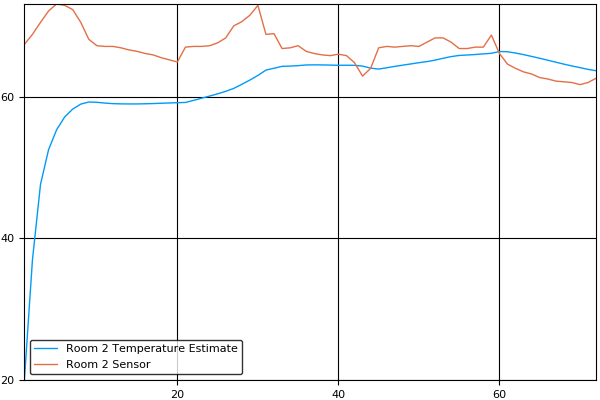

In [142]:
plot(vec(t), vec(T2_hat), label = "Room 2 Temperature Estimate")
plot!(vec(t), vec(T_2),label = "Room 2 Sensor")


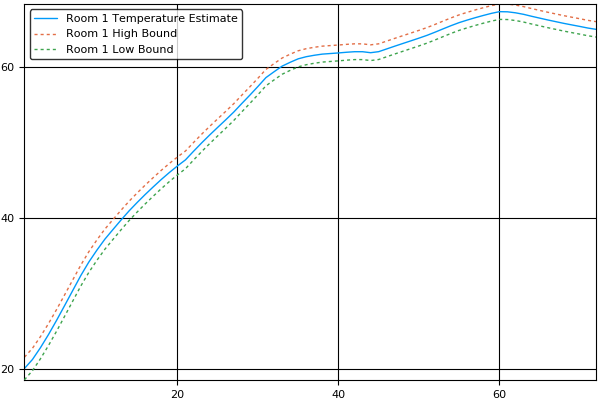

In [143]:
plot(vec(t), vec(T1_hat), label = "Room 1 Temperature Estimate")
plot!(vec(t), vec(T1_hat+bound1),label = "Room 1 High Bound", linestyle = :dot)
plot!(vec(t), vec(T1_hat-bound1),label = "Room 1 Low Bound", linestyle = :dot)


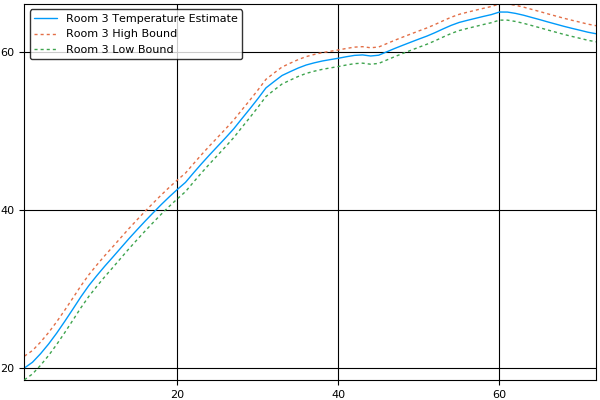

In [144]:
plot(vec(t), vec(T3_hat), label = "Room 3 Temperature Estimate")
plot!(vec(t), vec(T3_hat+bound1),label = "Room 3 High Bound", linestyle = :dot)
plot!(vec(t), vec(T3_hat-bound1),label = "Room 3 Low Bound", linestyle = :dot)

9.59258504888447

In [1]:
function kalman(x_hat,sig,A,B,C,D,ym,u,W,N)  # kalman filter for a general system

    # Compute Kalman Gain
    L = sig*C'*inv(N)

    # Kalman Filter equations
    y_hat = C*x_hat + D*u
    x_hat_dot =  A*x_hat + B*u + L*(ym - y_hat)

    # Riccati Equation for Sigma
    sig_dot = sig*A' + A*sig + W - sig*C'*inv(N)*C*sig

    # Return values
    return x_hat_dot, sig_dot
end

kalman (generic function with 1 method)

In [109]:
function kalmanRKF45(kf,A,B,C,D,ym,u,W,N,t,x_hat0,sig0)
    x_hat = x_hat_4 = x_hat_5 = zeros(3,length(t))  # vector of corresponding state values
    sig = sig_4 = sig_5 = fill(zeros(3,3), 1, length(t))
    x_hat[:,1] = x_hat0  # initial values
    sig = fill(zeros(3,3), 1, length(t))  # sigma is a vector of 3 by 3 matrices
    sig[1] = sig0
    f = (x_hat, sig, ym, u) -> kf(x_hat,sig,A,B,C,D,ym,u,W,N)
    h = (t[72]-t[1])/length(t) # set later
    tol = 2e-5 # set error control tolerance
    
    
    for i in 2:length(t)
        #t[i] = (i-1)*h+x_hat[:,1]
        F1 = [h*i for i in f(x_hat[:,i-1],sig[i-1],ym[i-1],u[:,i-1])]
        F2 = [h*i for i in f(x_hat[:,i-1]+(1/4)*F1[1],sig[i-1]+(1/4)*F1[2],ym[i-1],u[:,i-1])]
        F3 = [h*i for i in f(x_hat[:,i-1]+(3/32)*F1[1]+(9/32)*F2[1],sig[i-1]+(3/32)*F1[2]+(9/32)*F2[2],ym[i-1],u[:,i-1])]
        F4 = [h*i for i in f(x_hat[:,i-1]+(1932/2197)*F1[1]-(7200/2197)*F2[1]+(7296/2197)*F3[1],sig[i-1]+(1932/2197)*F1[2]-(7200/2197)*F2[2]+(7296/2197)*F3[2],ym[i-1],u[:,i-1])]
        F5 = [h*i for i in f(x_hat[:,i-1]+(439/216)*F1[1]-(8)*F2[1]+(3680/513)*F3[1]-(845/2104)*F4[1],sig[i-1]+(439/216)*F1[2]-(8)*F2[2]+(3680/513)*F3[2]-(845/2104)*F4[2],ym[i-1],u[:,i-1])]
        F6 = [h*i for i in f(x_hat[:,i-1]-(8/27)*F1[1]+(2)*F2[1]-(3544/2565)*F3[1]+(1859/4104)*F4[1]-(11/40)*F5[1],sig[i-1]-(8/27)*F1[2]+(2)*F2[2]-(3544/2565)*F3[2]+(1859/4104)*F4[2]-(11/40)*F5[2],ym[i-1],u[:,i-1])]  
        
        x_hat_4[:,i] = x_hat[:,i-1]+(25/216)*F1[1]+(1408/2565)*F3[1]+(2197/4101)*F4[1]-(1/5)*F5[1]  
        sig_4[i] = sig[i-1]+(25/216)*F1[2]+(1408/2565)*F3[2]+(2197/4101)*F4[2]-(1/5)*F5[2]
        
        x_hat[:,i] = x_hat_5[:,i] = x_hat[:,i-1]+(16/135)*F1[1]+(6656/12825)*F3[1]+(28561/56430)*F4[1]-(9/50)*F5[1]+(2/55)*F6[1]
        sig[i] = sig_5[i] = sig[i-1]+(16/135)*F1[2]+(6656/12825)*F3[2]+(28561/56430)*F4[2]-(9/50)*F5[2]+(2/55)*F6[2]
        
        if sig_5[i]-sig_4[i] == 0.
            scalar = ((tol*h)./(2*(sig_5[i]-sig_4[i])))^1/4
            println((2*(sig_5[i]-sig_4[i])))
            h = scalar*h
        end
    
    end
    return x_hat, sig

end

kalmanRKF45 (generic function with 1 method)